# Import Packages

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchsummary as summary
from sklearn.preprocessing import StandardScaler
import gc

from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Load DATA

In [2]:
# read DATA
data = pd.read_csv("C:/Users/bened/Documents/UNIVERSITY/SchoenStats/PyTorch Working Directory/Undergrad Stats Project/wave_data_gen_ugstprj.csv")
data.info()

# random sample from dataset
# DO NOT RUN BLOCK if testing under same data;
# ...or else dataset will be lost and new data sample
X = data.sample(10000).reset_index(drop=True)
X_train = torch.tensor(X.values)
X = data.sample(2000).reset_index(drop=True)
X_test = torch.tensor(X.values)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99117 entries, 0 to 99116
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       99117 non-null  float64
 1   y       99117 non-null  float64
dtypes: float64(2)
memory usage: 1.5 MB


Text(0.5, 1.0, 'Training Distribution')

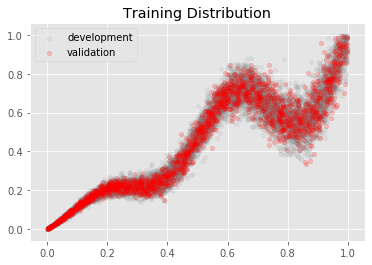

In [3]:
# plot generated dataset
plt.scatter(X_train[:,0], X_train[:,1], alpha=0.1, s=20, label='development', color='grey')
plt.scatter(X_test[:,0], X_test[:,1], alpha=0.2, s=20, label='validation', color='red')
plt.legend(loc='upper left')
plt.title("Training Distribution")

In [4]:
# create features data and target data
X_train = X_train.view(-1,2)
X_test = X_test.view(-1,2)

# Define MODEL and Loss Function

In [56]:
n_input = 1
n_output = 1
n_gaus = 3
n_hidden = 30
# define MODEL
class MDN(nn.Module):
    def __init__(self, n_hidden, n_gaussians):
        super(MDN, self).__init__()
        
        self.z_h = nn.Sequential(nn.Linear(n_input, n_hidden),
                                 nn.Tanh(),
                                 nn.Linear(n_hidden, n_hidden),
                                 nn.Tanh(),
                                 nn.Linear(n_hidden, n_hidden),
                                 nn.Tanh())
        
        self.z_pi = nn.Linear(n_hidden, n_gaussians)
        self.z_mu = nn.Linear(n_hidden, n_gaussians)
        self.z_sigma = nn.Linear(n_hidden, n_gaussians)
        
        #self.z_pi = nn.Linear(n_hidden, n_gaussians)
        #self.z_mu = nn.Linear(n_hidden, n_gaussians)
        #self.z_sigma = nn.Linear(n_hidden, n_gaussians)
    
    def forward(self, x):
        z_h = self.z_h(x)
        pi = F.softmax(self.z_pi(z_h), -1)
        mu = self.z_mu(z_h)
        sigma = torch.exp(self.z_sigma(z_h))
        return pi, mu, sigma

model = MDN(n_hidden=n_hidden, n_gaussians=n_gaus)

optimizer = torch.optim.Adam(model.parameters())

In [57]:
# defining LOSS function
# modification to the error loss function (because it is an MDN)
def mdn_loss_fn(y, mu, sigma, pi):
    m = torch.distributions.Normal(loc=mu, scale=sigma)
    loss = torch.exp(m.log_prob(y))
    loss = torch.sum(loss * pi, dim=1)
    loss = -torch.log(loss)
    return torch.mean(loss)

# Training Step

In [58]:
# TRAINING the model
num_epoch = 500
batch_size = 64

model=model.double()
loss_list = []

for epoch in tqdm(range(num_epoch)): 
    permu = torch.randperm(X_train.shape[0])
    
    for i in range(0, X_train.shape[0], batch_size):
        indices = permu[i:i+batch_size]
        batch_x, batch_y = X_train[indices,0], X_train[indices,1]
        pi, mu, sigma = model.forward(batch_x.unsqueeze(1))
        optimizer.zero_grad()
        l = mdn_loss_fn(batch_y.unsqueeze(1), mu, sigma, pi)
        l.backward()
        optimizer.step()

    if epoch % 1 == 0:
        loss_list.append(l.detach())

100%|██████████| 500/500 [06:41<00:00,  1.24it/s]


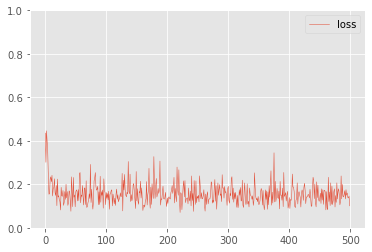

In [59]:
# Epochs vs (log)Loss
#plt.plot(range(num_epoch), np.array(loss_list), label='log.loss', linewidth=0.5)
#plt.ylim((-2.5, 0.5))
#plt.legend()

# Epochs vs Loss
plt.plot(range(num_epoch), np.exp(np.array(loss_list)), label='loss', linewidth=0.5)
plt.ylim((0, 1))
plt.legend()

# Sampling Data from Trained Model

In [60]:
pi, mu, sigma = model(X_test[:,0].unsqueeze(1))

In [61]:
# GENERATE samples from model
# first, extract model parameters
# pi - mixing coefficient
num_samples = 2000
pi, mu, sigma = model(X_test[:,0].unsqueeze(1))
# simulate mixture of gaussians
k = torch.multinomial(pi, 1).view(-1)
t_pred = torch.normal(mu, sigma)[np.arange(num_samples), k].data
t_pred = t_pred.view(-1, 1)

In [62]:
# function for rearranging data dependent on how many gaussians chosen
def mdn_col_sort(test, preds, n_gaus,
                 pi=pi, mu=mu, sigma=sigma) :
    
    data = torch.cat((test, preds, pi, mu, sigma), dim=1).detach().numpy()

    extra_cols = []
    for i in range(n_gaus):
        extra_cols.append('pi_' + str(i + 1))
    for j in range(n_gaus):
        extra_cols.append('mu_' + str(j + 1))
    for k in range(n_gaus):
        extra_cols.append('sigma_' + str(k + 1))
        
    col_names = ["X", "T", "T_pred"] + extra_cols
    data = pd.DataFrame(data, columns=col_names)
    
    # final sort for smoother plotting
    #data = data.sort_values(by='X', axis = 0)
    data['max_pi'] = ""
    
    return data

# create "max_pi" column which are labels for each row
# these indicate which pi value is the greatest
def add_max_pi(data, no_pi=2):
    pi_cols = []
    for i in range(no_pi):
        pi_cols.append('pi_' + str(i + 1))
    
    pi_dat = data[pi_cols]
    pi_dat.columns = range(1, no_pi+1)
    data.max_pi = pi_dat.idxmax(axis=1)
    
    return data

In [63]:
full_res = mdn_col_sort(X_test, t_pred, n_gaus)
full_res = full_res.sort_values(by='X')
full_res = add_max_pi(full_res, n_gaus)

#full_res.head(5)

# RESULTS

In [64]:
# special plot function
def plot_signif(no, data, col1='blue', col2='lightblue',
                a=0.4, lw=1.5, lw_m=2.0):
    
    plt.scatter(data['X'], data['T'], alpha=0.1, color='grey', s=10)
    n_dat = data[data.max_pi == no]
    
    mu_str = 'mu_'+ str(no)
    sigma_str = 'sigma_'+ str(no)
    
    plt.plot(n_dat['X'], n_dat[mu_str], color=col1,
             linewidth=lw_m, label=mu_str)
    plt.plot(data['X'], data[mu_str], '--',color=col1,
             alpha=a, linewidth=lw)
    plt.fill_between(n_dat['X'],
                 n_dat[mu_str]+n_dat[sigma_str],
                 n_dat[mu_str]-n_dat[sigma_str],
                 alpha=a, color=col2)

(0, 1)

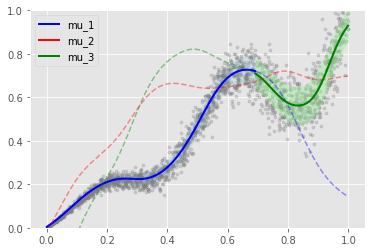

In [65]:
#plt.figure(figsize=[10, 7])

#plt.scatter(full_res['X'], full_res['T'], alpha=0.2, color='grey', s=10)

plot_signif(1, full_res)
plot_signif(2, full_res, col1='red', col2='pink')
plot_signif(3, full_res, col1='green', col2='lightgreen')
#plot_signif(4, full_res, col1='orange', col2='gold')
#plot_signif(5, full_res, col1='magenta', col2='pink')


plt.legend(loc='upper left', prop={'size': 10})
plt.ylim([0, 1])

#fig = plt.gcf()
#fig.savefig("MDN_wavedata_f2.png")
#plt.draw()

#plt.show()

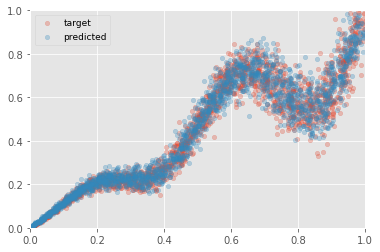

In [66]:
#plt.figure(figsize=[10, 7])
plt.scatter(X_test[:,0], X_test[:,1], alpha = 0.3, label='target', s=20)
plt.scatter(X_test[:,0], t_pred.detach(), alpha = 0.3, label = 'predicted', s=20)
plt.legend(loc='upper left')

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(loc='upper left', prop={'size':9})

#fig = plt.gcf()
#fig.savefig("MDN_pred_investigation.png")
#plt.draw()
#plt.show()

#plt.figure(figsize=(10, 7))

# Root Mean Square (RMS)

In [67]:
diff = (t_pred - X_test[:,1].view(-1, 1))
L2_diff = np.square(diff)

avg_diff = sum(np.array(L2_diff)) / num_samples
RMS = np.sqrt(avg_diff)
print("RMS: {}".format(np.around(RMS, decimals=6)))

RMS: [0.074624]


(0, 0.5)

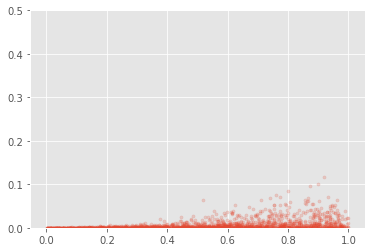

In [68]:
plt.scatter(X_test[:, 0].view(-1, 1), L2_diff, s=10, alpha=0.2)
plt.ylim((0,0.5))

(-0.5, 0.5)

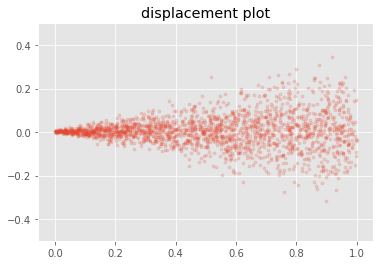

In [69]:
plt.scatter(X_test[:, 0].view(-1, 1), diff, s=10, alpha=0.2)
plt.title("displacement plot")
plt.ylim((-0.5,0.5))

# Log Likelihood

In [70]:
# log likelihood function for toy dataset
def toy_data_log_prob(t, x, var=0.09):
    lp_list =[]
    for i in tqdm(range(len(t))):
        sigma_sqr = float(0.09 * (x[i] ** 2))
        f = torch.distributions.normal.Normal(0, sigma_sqr)
        lp_list.append(f.log_prob(t[i]))
    return np.array(lp_list)

In [71]:
# calculation of loglikelihood
LL = sum(toy_data_log_prob(diff, X_test[:,0].view(-1, 1)))
print("Log-likelihood of predicted targets: {}".format(LL))

100%|██████████| 2000/2000 [00:00<00:00, 3124.77it/s]

Log-likelihood of predicted targets: -4576767295.689169


# Model Summary

In [72]:
# summary of model parameters
for name, param in model.named_parameters():
    print("{}\n{}\n".format(name, param))

z_h.0.weight
Parameter containing:
tensor([[-0.3513],
        [ 0.3902],
        [ 0.9608],
        [ 1.1113],
        [ 0.6783],
        [-0.8889],
        [-0.3137],
        [ 0.0472],
        [ 0.0789],
        [-0.1494],
        [ 1.1501],
        [-1.3466],
        [-0.8534],
        [ 1.1386],
        [-0.8614],
        [ 0.7388],
        [ 0.8658],
        [-0.6673],
        [-0.3621],
        [ 0.4465],
        [-1.3217],
        [ 0.7036],
        [ 1.3090],
        [-0.2983],
        [-0.9812],
        [ 0.3272],
        [-0.7585],
        [-0.5668],
        [-0.5362],
        [-0.7694]], dtype=torch.float64, requires_grad=True)

z_h.0.bias
Parameter containing:
tensor([ 0.0548,  0.0982, -0.0577, -0.0725, -0.5436,  0.0123,  0.5639, -0.0598,
        -0.0521,  0.0606, -0.7274, -0.6570,  0.7959, -0.5171,  0.3796, -0.7841,
        -0.6798,  0.5690,  0.3030, -0.7176,  0.1197, -0.5432, -0.0766, -0.3073,
         0.0595, -0.3058,  0.4211,  0.5278,  0.0065, -0.0669],
       dtype=tor